In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [10]:
df = pd.read_csv("./Data/Dataset_spine.csv")
df = df.iloc[:,:-1]
df.head()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Class_att
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,0.744503,12.5661,14.5386,15.30468,-28.658501,43.5123,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,0.415186,12.8874,17.5323,16.78486,-25.530607,16.1102,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,0.369345,23.5603,12.7074,11.42447,-30.470246,18.8329,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,0.543360,35.4940,15.9546,8.87237,-16.378376,24.9171,Abnormal


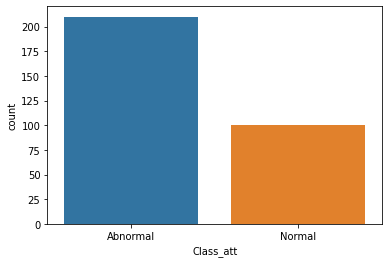

In [11]:
sns.countplot(x = 'Class_att', data=df)

### One Hot Encoding

In [12]:
df['Class_att'] = df['Class_att'].astype('category')
encode_map = {
    'Abnormal': 1,
    'Normal': 0
}

df['Class_att'].replace(encode_map, inplace=True)

### Creating Input and Output Data for model

In [13]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

### Train Test Split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=69)

### Standardization/Normalization

In [15]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Model Parameters

In [16]:
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

### Custom Data Loaders

In [23]:
## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))

In [24]:
## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = testData(torch.FloatTensor(X_test))

### Initializing DataLloader
#### We'll set batch size = 1 for test data set

In [25]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

### Custom Model Architecture

In [27]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(12, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [29]:
model = binaryClassification()
model.to(device)
print(model)

binaryClassification(
  (layer_1): Linear(in_features=12, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [30]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [40]:
y_pred_tag = torch.round(torch.sigmoid(torch.tensor([0.6])))
print(y_pred_tag)
(y_pred_tag == y_pred_tag).sum().float()

tensor([1.])


tensor(1.)

In [42]:
y_pred_tag.shape[0]

1

In [49]:
"""
Note that the inputs y_pred and y_test are for a batch. Our batch_size was 64. 
So, this accuracy is being calculated for 64 predictions(tensors) at a time.
"""

def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [50]:
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.01356 | Acc: 100.000
Epoch 002: | Loss: 0.01721 | Acc: 100.000
Epoch 003: | Loss: 0.01682 | Acc: 100.000
Epoch 004: | Loss: 0.02140 | Acc: 100.000
Epoch 005: | Loss: 0.03520 | Acc: 100.000
Epoch 006: | Loss: 0.02120 | Acc: 100.000
Epoch 007: | Loss: 0.06233 | Acc: 98.250
Epoch 008: | Loss: 0.03335 | Acc: 98.250
Epoch 009: | Loss: 0.02767 | Acc: 99.500
Epoch 010: | Loss: 0.02088 | Acc: 100.000
Epoch 011: | Loss: 0.05006 | Acc: 98.250
Epoch 012: | Loss: 0.10065 | Acc: 95.000
Epoch 013: | Loss: 0.03149 | Acc: 100.000
Epoch 014: | Loss: 0.03313 | Acc: 99.000
Epoch 015: | Loss: 0.15533 | Acc: 93.250
Epoch 016: | Loss: 0.05892 | Acc: 97.000
Epoch 017: | Loss: 0.02514 | Acc: 100.000
Epoch 018: | Loss: 0.02648 | Acc: 100.000
Epoch 019: | Loss: 0.02497 | Acc: 100.000
Epoch 020: | Loss: 0.02970 | Acc: 100.000
Epoch 021: | Loss: 0.01778 | Acc: 100.000
Epoch 022: | Loss: 0.01738 | Acc: 100.000
Epoch 023: | Loss: 0.03534 | Acc: 100.000
Epoch 024: | Loss: 0.08470 | Acc: 96.250
E

### Test the Model

In [69]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [71]:
confusion_matrix(y_test, y_pred_list)

array([[19, 12],
       [10, 62]])

In [72]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.66      0.61      0.63        31
           1       0.84      0.86      0.85        72

    accuracy                           0.79       103
   macro avg       0.75      0.74      0.74       103
weighted avg       0.78      0.79      0.78       103

